In [1]:
%pylab inline 
import gpipsfs
import glob, os
import astropy.io.fits as fits
import poppy
import astropy.units as u

Populating the interactive namespace from numpy and matplotlib


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


# Example calculations for GPI 2.0 coronagraph design work
## Including numerically-optimized shaped pupil APLC coronagraphs, and AO WFE models

## 1. Numerically-optimized shaped pupil APLCs

In [2]:
import webbpsf
webbpsf.setup_logging('none')

The following relies on having access to outputs from the `https://github.com/spacetelescope/aplc-optimization` APLC design toolkit. 

Set the following variable to your appropriate local path to such files. 

In [16]:
aplc_results_path = os.path.expanduser('~/Box/GPI_2_APLC/Surveys/gpi_aplc_2_test_N0300_telserv3')


# Find and load an apodizer design from a FITS file
apod_filename = glob.glob(os.path.join(aplc_results_path, 'solutions', '*.fits'))[0]
apod_npix = fits.getheader(apod_filename)['NAXIS1']

In [17]:
# Set up a GPI simulator instance with that apodizer, 
# and with the primary and Lyot stop adjusted to be symmetric
gpi = gpipsfs.GPI(custom_apodizer_path=apod_filename,  npix=apod_npix, display_before=False, 
                  lyot_tabs=False, force_symmetric_primary = False)
gpi.options['output_mode'] = 'oversampled' # return oversampled arrays (rather than binning to IFS resolution)
oversampling=4

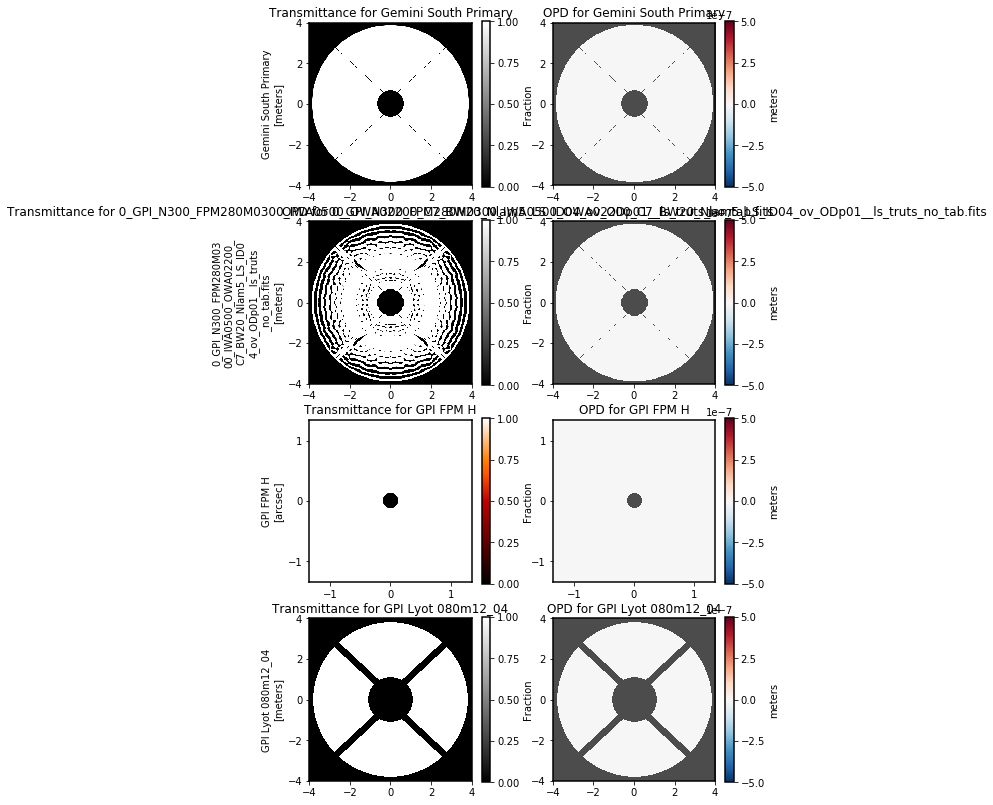

In [18]:
# Display the optical system to see what masks are configured
plt.figure(figsize=(8,14))
gpi.display()

Compute the wavelength for which the ratio of FPM diameter / _lambda/D_ is precisely consistent with the APLC design code. 

In [23]:
fpm_r = gpipsfs.GPI_FPM("H").radius*u.milliarcsecond
d_pri = gpipsfs.GeminiPrimary.primary_diameter*u.m
apod_header = fits.getheader(apod_filename)
fpm_in_lambdaD = apod_header['FPM_RAD']

ref_wavelen = (fpm_r.to_value(u.radian)*d_pri / fpm_in_lambdaD).to_value(u.m)

print(f"APLC design optimized for FPM = {fpm_in_lambdaD} lam/D. For the GPI H FPM, that equality is true at {ref_wavelen*1e6:.3f} microns")


APLC design optimized for FPM = 2.8 lam/D. For the GPI H FPM, that equality is true at 1.645 microns


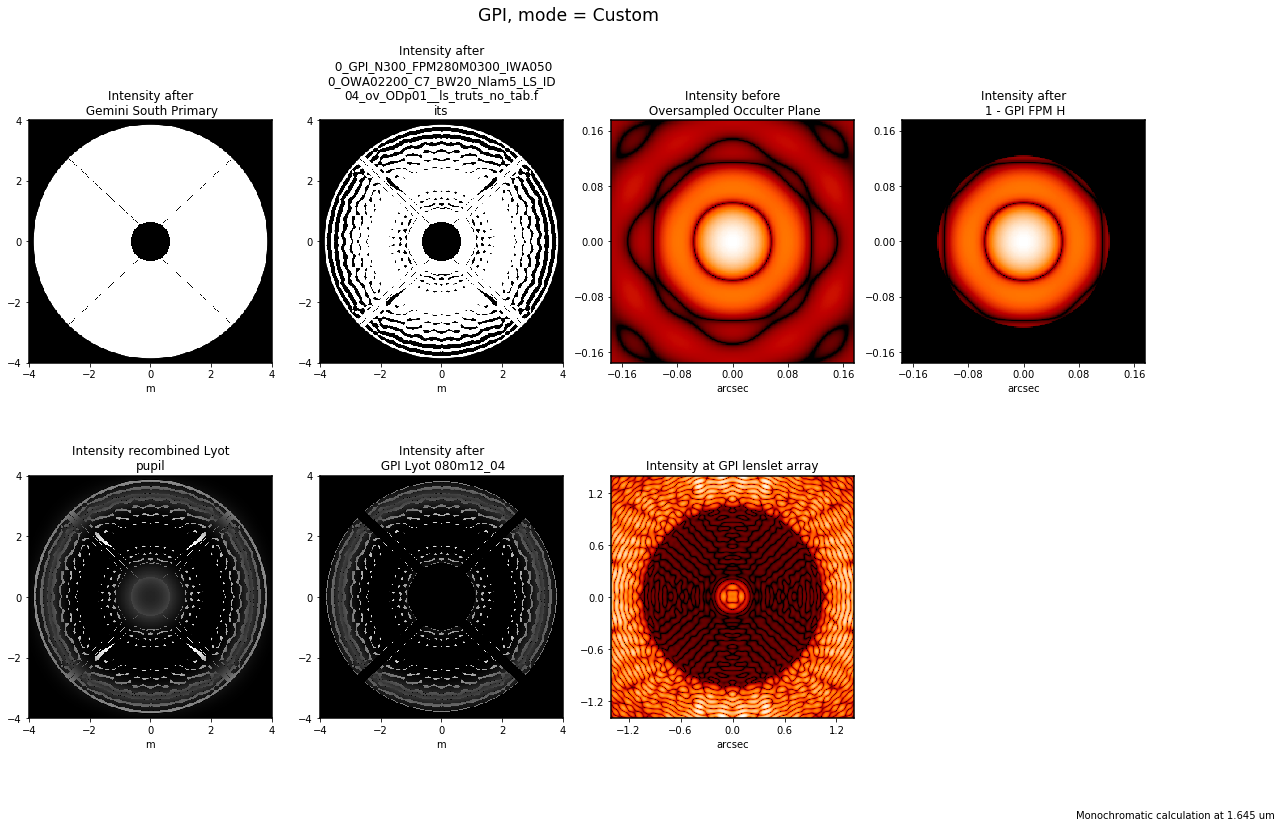

In [24]:
# Perform a basic PSF calculation, with display enabled. 
# This now uses the fast semianalytic method for  high res sampling of the FPM 
plt.figure(figsize=(20,12))
psf = gpi.calc_psf(monochromatic=ref_wavelen, display=True, oversample=oversampling)

In [25]:
gpi.include_fpm = False
direct_psf = gpi.calc_psf(monochromatic=ref_wavelen, display=False, oversample=oversampling)
gpi.include_fpm = True

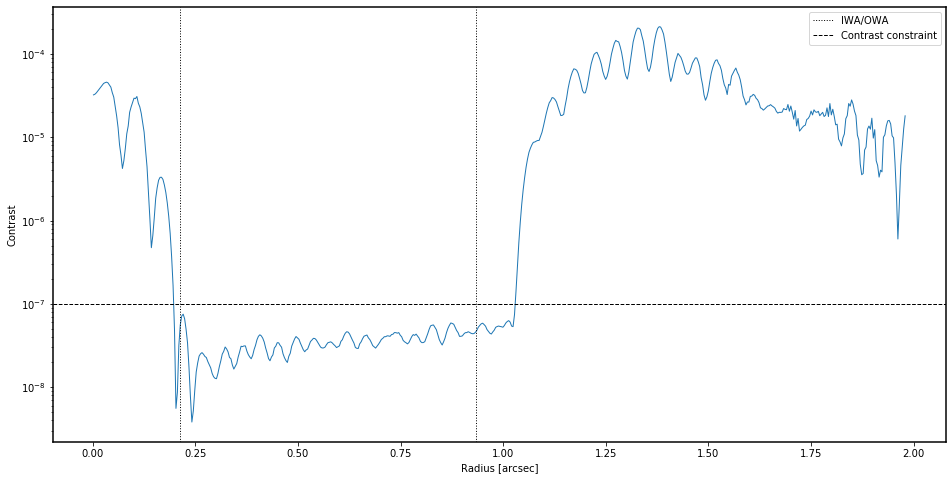

In [26]:
# Display PSF radial profile, and annotate
apod_header = fits.getheader(apod_filename)
lamd = psf[0].header['DIFFLMT']

plt.figure(figsize=(16,8))
gpipsfs.plot_contrast(psf, direct_psf)


ax = plt.gca()
ax.axvline(apod_header['IWA']*lamd, color='black', ls=':', label='IWA/OWA')
ax.axvline(apod_header['OWA']*lamd, color='black', ls=':')
ax.axhline(apod_header['CONTRAST'], color='black', ls='--' , label='Contrast constraint')

ax.legend()


# 2. Cross-check of optimizer input masks with gpipsfs

Let's verify we are using consistent masks here and in the APLC optimization code. 

In [27]:
primary_fn = glob.glob(os.path.join(aplc_results_path, 'inputs', '*Primary*.fits'))[0]
lyot_fn = glob.glob(os.path.join(aplc_results_path, 'inputs', '*LS*.fits'))[0]
primary_fn, lyot_fn

('/Users/mperrin/Box/GPI_2_APLC/Surveys/gpi_aplc_2_test_N0300_telserv3/inputs/Primary_GPI_SpidTrue_N0300.fits',
 '/Users/mperrin/Box/GPI_2_APLC/Surveys/gpi_aplc_2_test_N0300_telserv3/inputs/LS_GPI_080m12_04_ovsamp01_struts_no_tabs_N0300.fits')

1.2401329683024491e-14


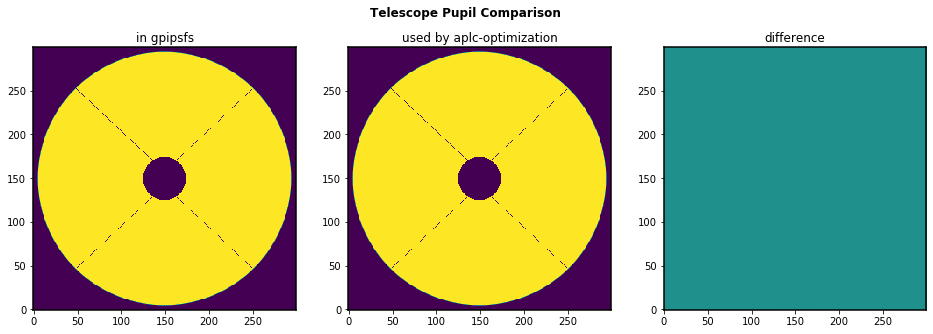

In [28]:
osys = gpi.get_optical_system()

primary_poppy = osys.planes[0].sample(npix=apod_npix)
primary_fits = fits.getdata(primary_fn)

fig, axes = plt.subplots(figsize=(16,5), ncols=3)

axes[0].imshow(primary_poppy)
axes[0].set_title("in gpipsfs")

axes[1].imshow(primary_fits)
axes[1].set_title("used by aplc-optimization")

axes[2].imshow(primary_fits - primary_poppy, vmin=-1, vmax=1)
axes[2].set_title("difference")


plt.suptitle("Telescope Pupil Comparison", fontweight='bold')
print(np.abs(primary_fits - primary_poppy).sum() / primary_poppy.sum())

0.0


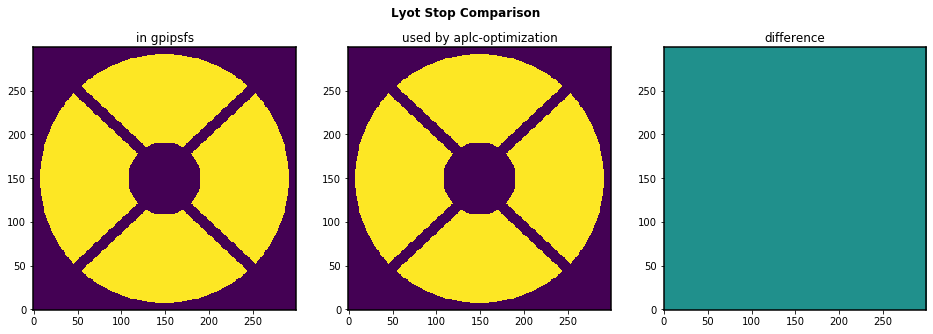

In [29]:
lyotstop_poppy = osys.planes[-2].sample(npix=300)
lyotstop_fits = fits.getdata(lyot_fn)

fig, axes = plt.subplots(figsize=(16,5), ncols=3)

axes[0].imshow(lyotstop_poppy)
axes[0].set_title("in gpipsfs")

axes[1].imshow(lyotstop_fits)
axes[1].set_title("used by aplc-optimization")

axes[2].imshow(lyotstop_fits - lyotstop_poppy, vmin=-1, vmax=1)
axes[2].set_title("difference")

plt.suptitle("Lyot Stop Comparison", fontweight='bold')
print(np.abs(lyotstop_fits - lyotstop_poppy).sum() / lyotstop_poppy.sum())

# 3. Comparison with existing GPI design

Here we compute PSFs for both the current GPI coronagraph design and the new optimizer output. This is for the zero-WFE case; we'll add wavefront error below. 

For this comparison focused on the coronagraph mask designs, we turn off the satellite spots and Lyot stop tabs. (THis is not something you can turn off in real GPI)

In [30]:
current_gpi = gpipsfs.GPI(display_before=False, 
                  lyot_tabs=False, force_symmetric_primary = False)
current_gpi.satspots=False
current_gpi.options['output_mode'] = 'oversampled' # return oversampled arrays (rather than binning to IFS resolution)

current_gpi.obsmode = 'H_coron'

current_gpi.include_fpm = False
direct_psf_H_coron = current_gpi.calc_psf(monochromatic=ref_wavelen, display=False, oversample=oversampling)
current_gpi.include_fpm = True
psf_H_coron = current_gpi.calc_psf(monochromatic=ref_wavelen, display=False, oversample=oversampling)

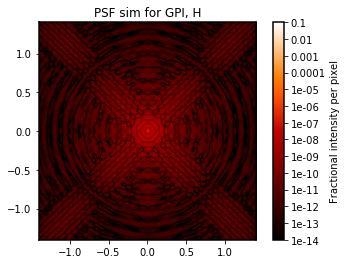

In [31]:
poppy.display_psf(psf_H_coron, vmin=1e-14)

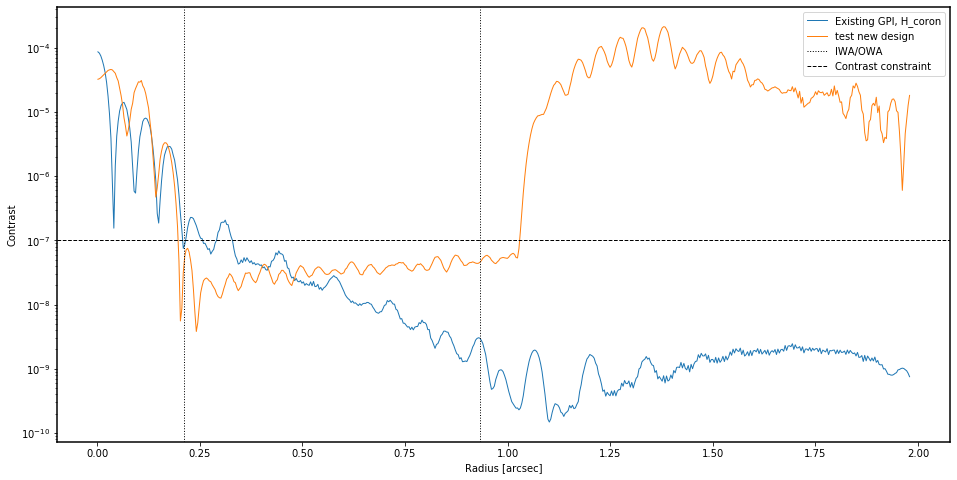

In [32]:
# Display PSF radial profile, and annotate
apod_header = fits.getheader(apod_filename)
lamd = psf[0].header['DIFFLMT']

plt.figure(figsize=(16,8))
gpipsfs.plot_contrast(psf_H_coron, direct_psf_H_coron, label='Existing GPI, H_coron')
gpipsfs.plot_contrast(psf, direct_psf, label='test new design')

ax = plt.gca()
ax.axvline(apod_header['IWA']*lamd, color='black', ls=':', label='IWA/OWA')
ax.axvline(apod_header['OWA']*lamd, color='black', ls=':')
ax.axhline(apod_header['CONTRAST'], color='black', ls='--' , label='Contrast constraint')

ax.legend()

# 4. Modeling AO Wavefront Error 

## 4.1 Importing AO WFE files

First we import the AOWFE file provided by Jerome, and convert to a format and units more compatible with poppy use.  

This requires access to a file downloaded from the GPI shared area on Google drive. 

This part only has to be done once, and we save the output to be reused for many PSF simulations after that. 

In [33]:
aowfe_path = '/Users/mperrin/data/GPI_2.0/resPhi.fits'
aowfe_cube = fits.getdata(aowfe_path).transpose() # put in to t,x,y order

In [ ]:
import scipy
def convert_aowfe_file(filename, npix, start_slice=400, stop_slice=500,):
    """Convert AO WFE residuals files from GPI 2.0 AO sims to what poppy/gpipsfs expects
    
    """
    
    pupil_array_diameter = 8.0*u.m
    
    aowfe_cube = fits.getdata(filename).transpose() # put in to t,x,y order
    # Read the WFE directly from that array, and stick that together with the primary aperture
    aowfe_cube *= 1e-9   # convert from nm to meters

    pixscale_apod = pupil_array_diameter / (npix * u.pixel) # This is an assumption! True so far for GPI 2.0 mask files...

    # If we aren't explicitly told the pixelscale for the WFE, we assume the provided array matches the
    # Gemini entrance pupil size, because that's true for the GPI 2.0 AO sims
    pixscale_aowfe = gpipsfs.GeminiPrimary.primary_diameter*u.m / (aowfe_cube.shape[1]*u.pixel)

    # We want to resample and pad the provided WFE array to have consistent sampling with the apodizer array
    scalefactor = (pixscale_aowfe / pixscale_apod).value
    
    zoomed_aowfe_cube = np.zeros((stop_slice-start_slice, npix, npix))
    
    for i_out, i_slice in enumerate(range(start_slice, stop_slice)):
        wfe = aowfe_cube[i_slice]
        wfe -= wfe.mean()
        zoomed_slice = scipy.ndimage.zoom(wfe, scalefactor)
        zoomed_aowfe_cube[i_out] = poppy.utils.pad_to_size(zoomed_slice, (npix, npix))

    hd = fits.PrimaryHDU(data=zoomed_aowfe_cube)
    hd.header['PIXELSCL'] = (pixscale_apod.to_value(u.m/u.pixel), "Pixelscale [m/pix]")
    hd.header['ORIGINAL'] = filename
    hd.header['CONTENTS'] = ('OPD', "Contents: optical path difference data")
    hd.header['BUNIT'] = ('m', 'Data units are meters of OPD')
    
    return hd

results = convert_aowfe_file(aowfe_path, 300, start_slice=400, stop_slice=500)

results.writeto(new_wfe_file, overwrite=True)

In [34]:


new_wfe_file = "/Users/mperrin/data/GPI_2.0/resPhi_converted.fits"
gpi.pupilopd = new_wfe_file

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb21a19bcd0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb21a16db10>)

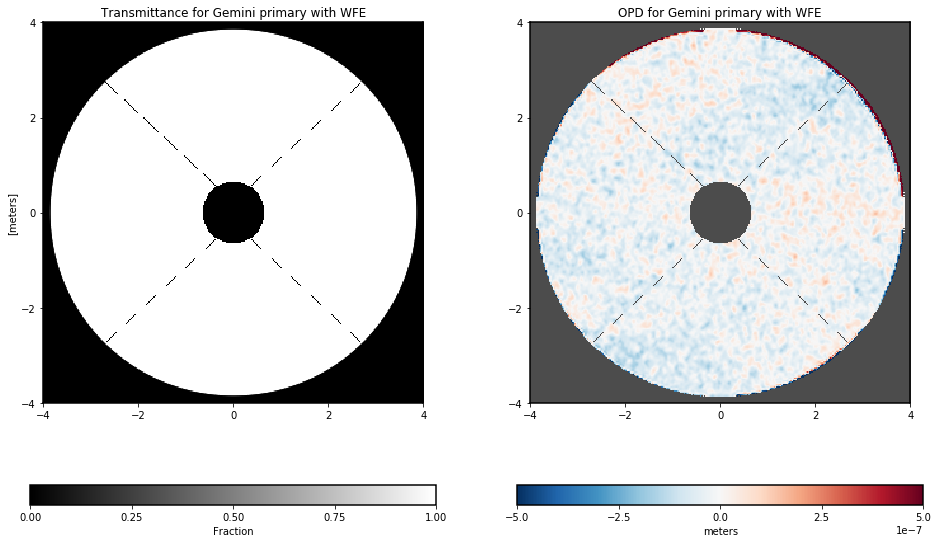

In [35]:
plt.figure(figsize=(16,10))
gpi.get_optical_system().planes[0].display(what='both')

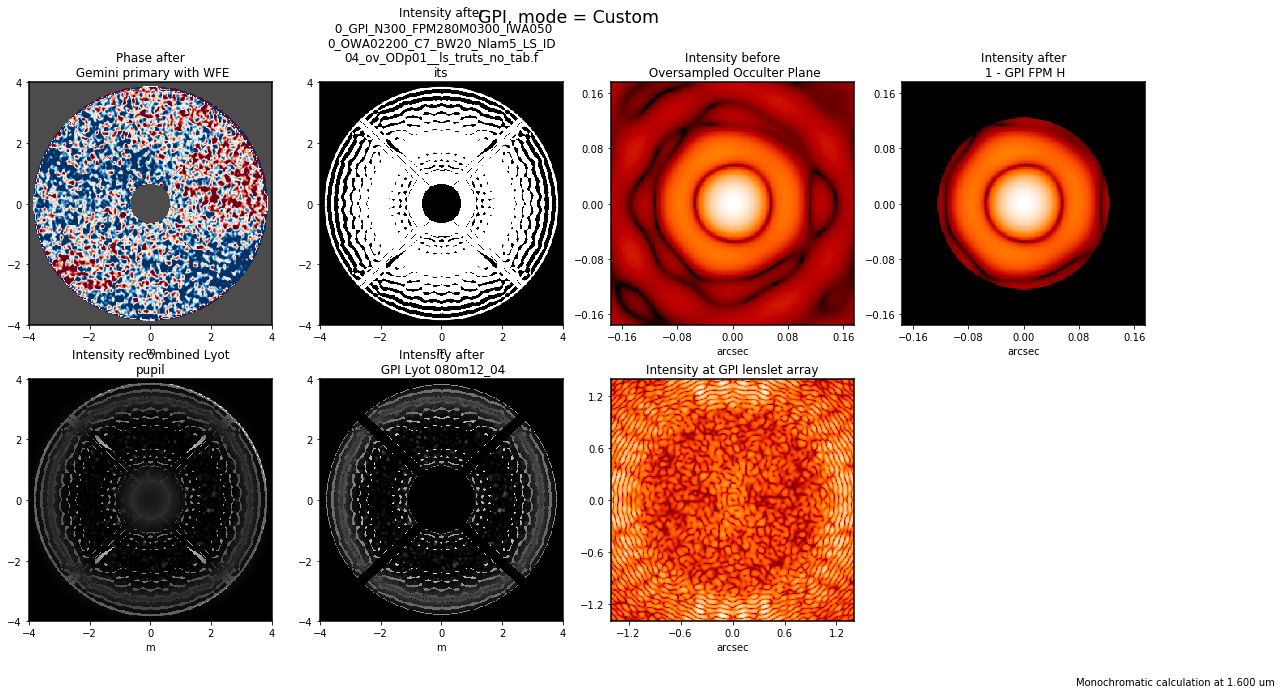

In [38]:
# Calculate PSF with WFE
plt.figure(figsize=(20,10))

# Optional, change which time step within that OPD file is used: 
gpi.opd_slice = 20

psf, waves = gpi.calc_psf(monochromatic=1.6e-6, display=True, oversample=2, return_intermediates=True)

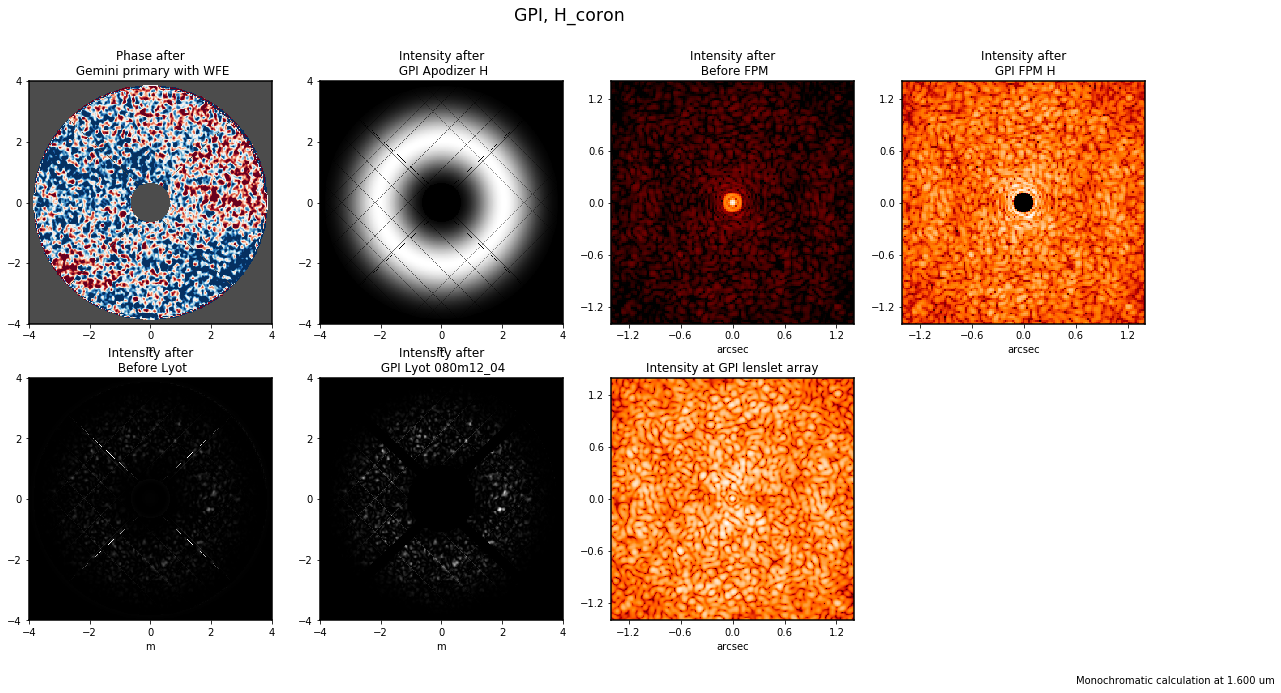

In [10]:
plt.figure(figsize=(20,10))
gpi.obsmode = 'H_coron'

psf, waves = gpi.calc_psf(monochromatic=1.6e-6, display=True, oversample=2, return_intermediates=True)

KeyboardInterrupt: 

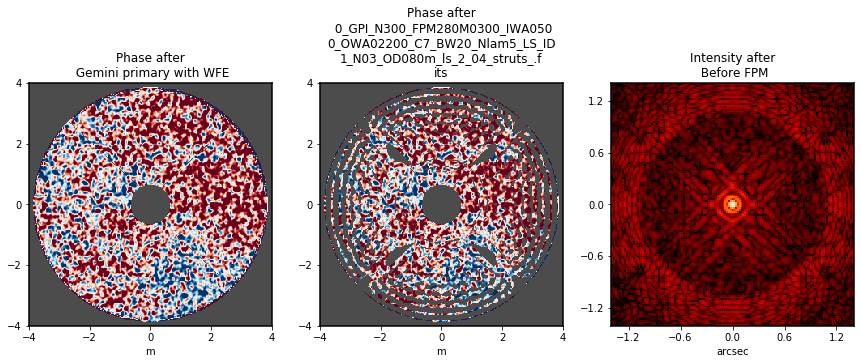

In [12]:
plt.figure(figsize=(20,10))

psfs = []

for i in range(100):
    gpi.opd_slice = i
    psf= gpi.calc_psf(monochromatic=1.6e-6, display=True, oversample=2)
    plt.savefig(f"psf_example_{i:03d}.png")
    psfs.append(psf)

import copy
tot_psf = copy.deepcopy(psfs[0])

for i in range(1, nslice):
    tot_psf[0].data += psfs[i][0].data

tot_psf[0].data /= nslice

In [29]:
def calc_psf_one_timestep(i):
    gpi.slice = i
    return gpi.calc_psf(monochromatic=1.6e-6,oversample=4)

calc_psf_one_timestep(10)

In [1]:
import multiprocessing
def f(x):
    return x + 1

if __name__ == '__main__':
    with multiprocessing.get_context('spawn').Pool() as pool:
        print(pool.map(f, range(10)))


KeyboardInterrupt: 

In [22]:
psfs = []

nslice=20
for i in range(nslice):
    gpi.slice = i
    psfs.append(gpi.calc_psf(monochromatic=1.6e-6,oversample=4))

In [24]:
import copy
tot_psf = copy.deepcopy(psfs[0])

for i in range(1, nslice):
    tot_psf[0].data += psfs[i][0].data

tot_psf[0].data /= nslice


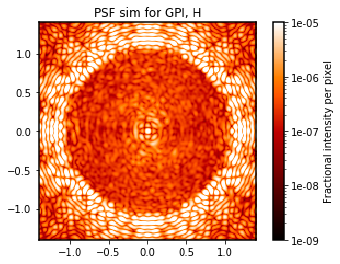

In [28]:
poppy.display_psf(tot_psf, vmax=1e-5, vmin=1e-9)

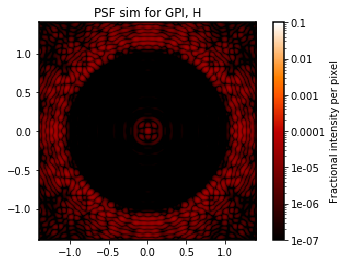

In [8]:
poppy.display_psf(psf)

In [12]:
lamd = psf[0].header['DIFFLMT']


lamd

0.04125296124941927

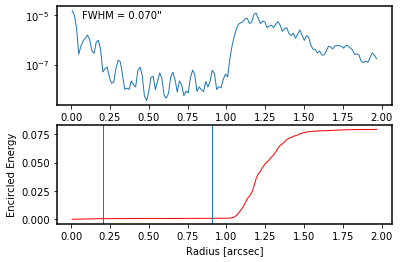

In [9]:
poppy.display_profiles(psf)
lamd = psf[0].header['DIFFLMT']

plt.axvline(5*lamd)
plt.axvline(22*lamd)

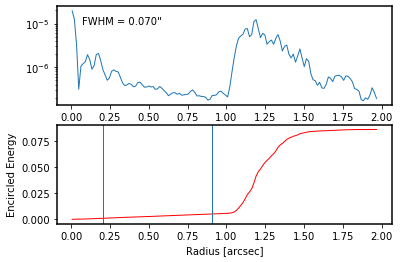

In [9]:
poppy.display_profiles(psf)
lamd = psf[0].header['DIFFLMT']

plt.axvline(5*lamd)
plt.axvline(22*lamd)

# Calculate PSF with FPM radius=2.8 lam/D precisely

Pick the wavelength where this is true

In [10]:
lamd

0.04125296124941927

In [11]:
gpipsfs.GPI_FPM.FPM_table['H'] / 2.8 / 2 / 1000

0.04405357142857143

In [12]:
gpipsfs.GPI_FPM.FPM_table['H'] / 2.8 / 2000 / lamd * 1.6e-6

1.7086219304246074e-06

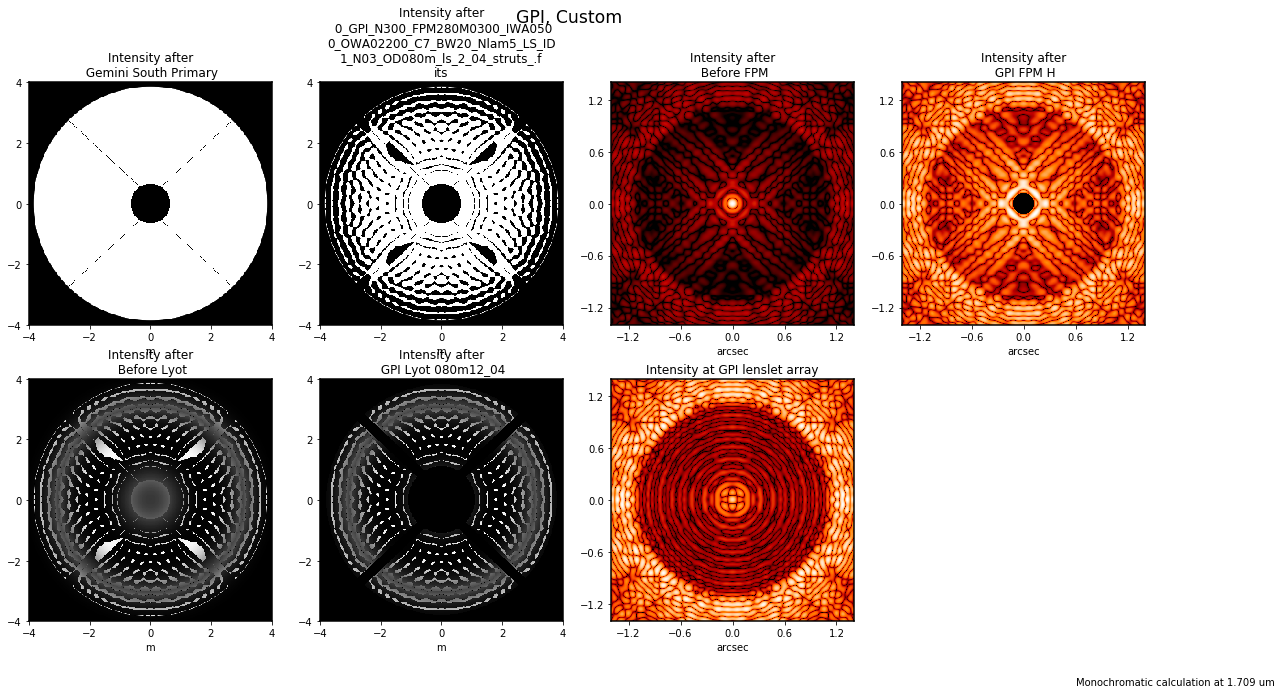

In [13]:

# What wavelength makes the FPM precisely 2.8 lam/D across? 
ref_wl = gpipsfs.GPI_FPM.FPM_table['H'] / 2.8 / 2000 / lamd * 1.6e-6

plt.figure(figsize=(20,10))
psf, waves = gpi.calc_psf(monochromatic=ref_wl, display=True, oversample=8, return_intermediates=True)

0.04405357142857143 0.12334999999999999 123.35


/Users/mperrin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


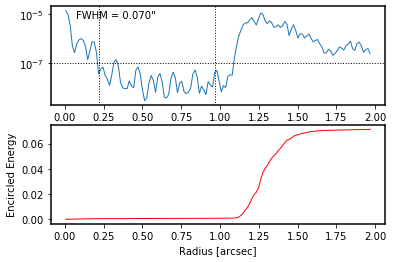

In [14]:
axes = poppy.display_profiles(psf)
lamd = psf[0].header['DIFFLMT']
print(lamd, 2.8*lamd, gpipsfs.GPI_FPM.FPM_table['H']/2)

ax = plt.subplot(2, 1, 1)

ax.axvline(5*lamd, color='black', ls=":")
ax.axvline(22*lamd, color='black', ls=":")
ax.axhline(1e-7, color='black', ls=":")

In [15]:
osys = gpi.get_optical_system()

In [16]:
[(p, p.name) for p in osys.planes]

[(<gpipsfs.main.GeminiPrimary at 0x7ffe81581750>, 'Gemini South Primary'),
 (<gpipsfs.main.OptimizedGPIApodizer at 0x7ffe815818d0>,
  '0_GPI_N300_FPM280M0300_IWA0500_OWA02200_C7_BW20_Nlam5_LS_ID1_N03_OD080m_ls_2_04_struts_.fits'),
 (<poppy.optics.ScalarTransmission at 0x7ffeb2e93cd0>, 'Before FPM'),
 (<gpipsfs.main.GPI_FPM at 0x7ffeb2e935d0>, 'GPI FPM H'),
 (<poppy.optics.ScalarTransmission at 0x7ffeb2e93090>, 'Before Lyot'),
 (<gpipsfs.main.GPI_LyotMask at 0x7ffeb2e93790>, 'GPI Lyot 080m12_04'),
 (<poppy.poppy_core.Detector at 0x7ffeb2e93250>, 'GPI lenslet array')]

In [17]:
pup = osys.planes[0].sample(npix=300)

In [18]:
primary_fn = glob.glob(os.path.join(aplc_results_path, 'inputs', '*primary*.fits'))[0]
lyot_fn = glob.glob(os.path.join(aplc_results_path, 'inputs', '*LS*.fits'))[0]
primary_fn

'/Users/mperrin/Box/GPI_2_APLC/Surveys/gpi_2_aplc_N0300_telserv3/inputs/GPI_primary_N0300.fits'

# Comparison of masks

Text(0.5, 0.98, 'Telescope Pupil Comparison')

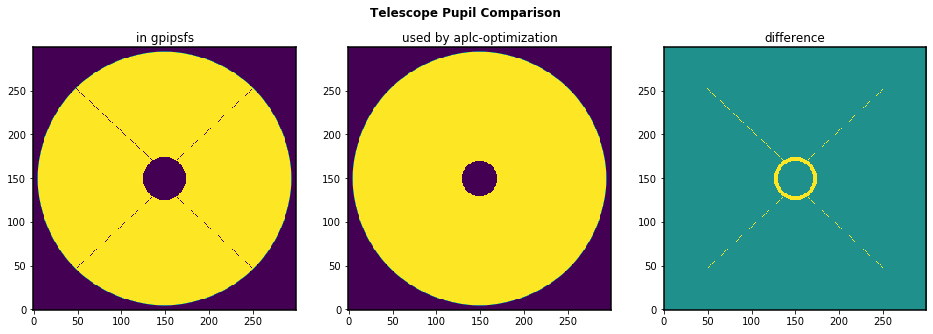

In [19]:
primary_fn = glob.glob(os.path.join(aplc_results_path, 'inputs', '*primary*.fits'))[0]
lyot_fn = glob.glob(os.path.join(aplc_results_path, 'inputs', '*LS*.fits'))[0]
primary_fn


primary_poppy = osys.planes[0].sample(npix=300)
primary_fits = fits.getdata(primary_fn)

fig, axes = plt.subplots(figsize=(16,5), ncols=3)

axes[0].imshow(primary_poppy)
axes[0].set_title("in gpipsfs")

axes[1].imshow(primary_fits)
axes[1].set_title("used by aplc-optimization")

axes[2].imshow(primary_fits - primary_poppy, vmin=-1, vmax=1)
axes[2].set_title("difference")


plt.suptitle("Telescope Pupil Comparison", fontweight='bold')

Text(0.5, 0.98, 'Lyot Stop Comparison')

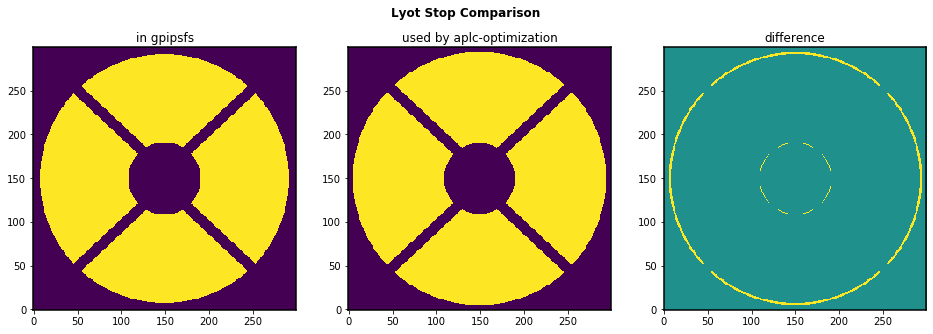

In [20]:
lyotstop_poppy = osys.planes[-2].sample(npix=300)
lyotstop_fits = fits.getdata(lyot_fn)

fig, axes = plt.subplots(figsize=(16,5), ncols=3)

axes[0].imshow(lyotstop_poppy)
axes[0].set_title("in gpipsfs")

axes[1].imshow(lyotstop_fits)
axes[1].set_title("used by aplc-optimization")

axes[2].imshow(lyotstop_fits - lyotstop_poppy, vmin=-1, vmax=1)
axes[2].set_title("difference")

plt.suptitle("Lyot Stop Comparison", fontweight='bold')

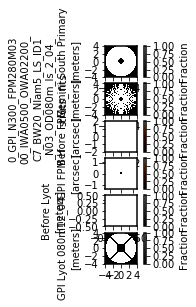

In [21]:
osys.display()

In [22]:
hdu = gpipsfs.GeminiPrimary().to_fits(npix=300)

In [23]:
gpipsfs.GeminiPrimary().to_fits(npix=300)[0].header['PIXELSCL']

0.02666666666666667

In [24]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  300                                                  
NAXIS2  =                  300                                                  
EXTEND  =                    T                                                  
OPTIC   = 'Gemini South Primary' / Descriptive name of this optic               
NAME    = 'Gemini South Primary'                                                
SOURCE  = 'Computed with POPPY'                                                 
VERSION = '0.9.2.dev16+g33c8857.d20200820' / software version of POPPY          
CONTENTS= 'amplitude'          / Electric field amplitude transmission          
PLANETYP=                    0 / 0=unspecified, 1=pupil, 2=image, 3=detector, 4=
PUPLSCAL=  0.026666666666666

# Reading in the AO simulations

In [6]:
aowfe_path = '/Users/mperrin/data/GPI_2.0/resPhi.fits'
aowfe_cube = fits.getdata(aowfe_path).transpose() # put in to t,x,y order

In [7]:
aowfe_cube.shape

(10000, 176, 176)

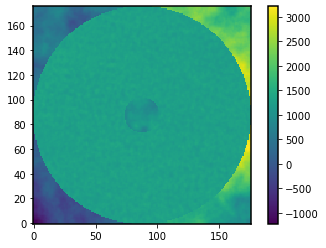

In [8]:
plt.imshow(aowfe_cube[900])
plt.colorbar()

In [43]:
pixscale = 8.0*u.m / (300*u.pixel)
pixscale.to_value(u.m/u.pixel)

0.02666666666666667

In [47]:
import scipy
def convert_aowfe_file(filename, npix, start_slice=400, stop_slice=500,):
    """Convert AO WFE residuals files from GPI 2.0 AO sims to what poppy/gpipsfs expects
    
    """
    
    pupil_array_diameter = 8.0*u.m
    
    aowfe_cube = fits.getdata(filename).transpose() # put in to t,x,y order
    # Read the WFE directly from that array, and stick that together with the primary aperture
    aowfe_cube *= 1e-9   # convert from nm to meters

    pixscale_apod = pupil_array_diameter / (npix * u.pixel) # This is an assumption! True so far for GPI 2.0 mask files...

    # If we aren't explicitly told the pixelscale for the WFE, we assume the provided array matches the
    # Gemini entrance pupil size, because that's true for the GPI 2.0 AO sims
    pixscale_aowfe = gpipsfs.GeminiPrimary.primary_diameter*u.m / (aowfe_cube.shape[1]*u.pixel)

    # We want to resample and pad the provided WFE array to have consistent sampling with the apodizer array
    scalefactor = (pixscale_aowfe / pixscale_apod).value
    
    zoomed_aowfe_cube = np.zeros((stop_slice-start_slice, npix, npix))
    
    for i_out, i_slice in enumerate(range(start_slice, stop_slice)):
        wfe = aowfe_cube[i_slice]
        wfe -= wfe.mean()
        zoomed_slice = scipy.ndimage.zoom(wfe, scalefactor)
        zoomed_aowfe_cube[i_out] = poppy.utils.pad_to_size(zoomed_slice, (npix, npix))

    hd = fits.PrimaryHDU(data=zoomed_aowfe_cube)
    hd.header['PIXELSCL'] = (pixscale_apod.to_value(u.m/u.pixel), "Pixelscale [m/pix]")
    hd.header['ORIGINAL'] = filename
    hd.header['CONTENTS'] = ('OPD', "Contents: optical path difference data")
    hd.header['BUNIT'] = ('m', 'Data units are meters of OPD')
    
    return hd

results = convert_aowfe_file(aowfe_path, 300, start_slice=400, stop_slice=500)

results.writeto(new_wfe_file, overwrite=True)

In [48]:
results.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  300                                                  
NAXIS2  =                  300                                                  
NAXIS3  =                  100                                                  
EXTEND  =                    T                                                  
PIXELSCL=  0.02666666666666667 / Pixelscale [m/pix]                             
ORIGINAL= '/Users/mperrin/data/GPI_2.0/resPhi.fits'                             
CONTENTS= 'OPD     '           / Contents: optical path difference data         
BUNIT   = 'm       '           / Data units are meters of OPD                   

In [6]:
new_wfe_file = "/Users/mperrin/data/GPI_2.0/resPhi_converted.fits"
gpi.pupilopd = new_wfe_file

plt.figure(figsize=(16,16))
gpi.display()

UnboundLocalError: local variable 'pixscale_apod' referenced before assignment

<Figure size 1152x1152 with 0 Axes>

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

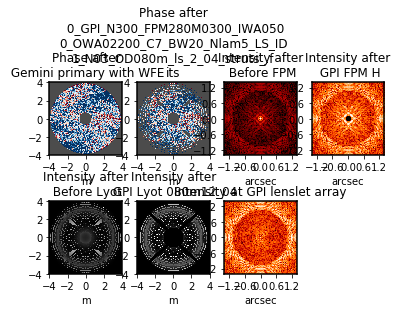

In [16]:
psf_with_wfe = gpi.calc_psf(monochromatic=1.6e-6, display=True, oversample=2, return_intermediates=True)

In [32]:
gpi.pupilopd.__class__

numpy.ndarray

In [71]:
7.7/176

0.043750000000000004

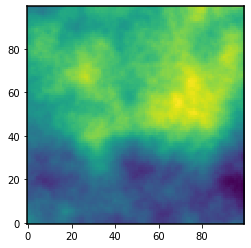

In [84]:
plt.imshow(aowfe_cube[0, 40:140,40:140])

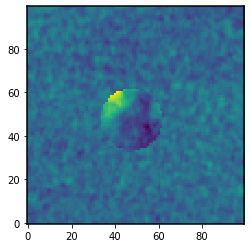

In [72]:
plt.imshow(aowfe_cube[400, 40:140,40:140])

In [74]:
np.std(aowfe_cube[400, 40:140,40:140])

60.493065

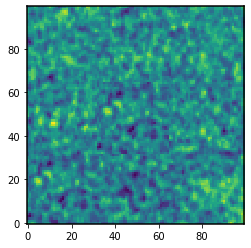

In [97]:
tmp = aowfe_cube[300, 40:140,40:140]*1.0
tmp[32:65, 32:65] = tmp[0:33,0:33]
tmp -= tmp.mean()
plt.imshow(tmp)

In [98]:
np.sqrt((tmp**2).mean())

45.675568

In [94]:
tmp.mean()

4.6875e-06

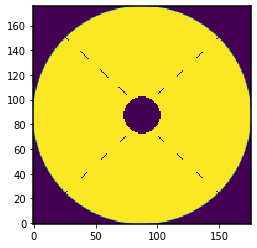

In [117]:
pri = gpipsfs.GeminiPrimary().sample(npix=data.shape[0], 
                               grid_size=gpipsfs.GeminiPrimary.primary_diameter)
plt.imshow(pri)

In [118]:
data = aowfe_cube[300] * 1e-9

data -= data.mean()

# We need to set the entrance pupil appropriately here
#trans = np.ones_like(data)
primary_trans = gpipsfs.GeminiPrimary().sample(npix=data.shape[0], 
                               grid_size=gpipsfs.GeminiPrimary.primary_diameter)


opd = poppy.ArrayOpticalElement(opd=data, transmission=primary_trans,
                                pixelscale = 7.7*u.m/(data.shape[0]*u.pixel))

In [124]:
8.0/(7.701/176)

182.83339825996623

In [133]:
import scipy

In [157]:
gpipsfs.GeminiPrimary.primary_diameter

7.701

In [154]:
wfe = data

wfe -= wfe.mean()

apod_npix = 300
pixscale_apod =  gpipsfs.GeminiPrimary._default_display_size / (apod_npix*u.pixel)

# If we aren't explicitly told the pixelscale for the WFE, we assume the provided array matches the 
# Gemini entrance pupil size, because that's true for the GPI 2.0 AO sims
pixscale_aowfe = GeminiPrimary.primary_diameter*u.m/(wfe.shape[0]*u.pixel)

# We want to resample and pad the provided WFE array to have consistent sampling with the apodizer array
scalefactor = (pixscale_aowfe / pixscale_apod).value
zoomed_data = poppy.utils.pad_to_size(scipy.ndimage.zoom(data, scalefactor), (apod_npix, apod_npix))

# Now combine both the amplitude and OPD terms into a single optical element model
primary_trans = gpipsfs.GeminiPrimary().sample(npix=apod_npix, 
                               grid_size=gpipsfs.GeminiPrimary._default_display_size)

pupil_obj = poppy.ArrayOpticalElement(opd=zoomed_data, transmission=primary_trans,
                                pixelscale = pixscale_apod, name='Gemini primary with WFE')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb82a44a410>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb82a44ab90>)

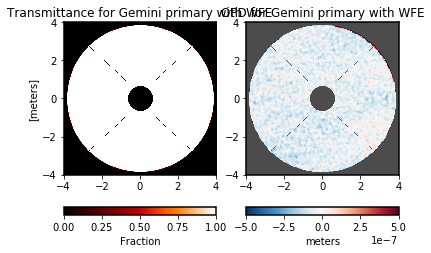

In [155]:
plt.figure(figsize)
pupil_obj.display(what='both')

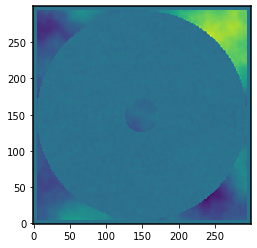

In [147]:
plt.imshow(zoomed_data)

In [127]:
pixscale_apod

0.02567

In [32]:
opd.display(what='both')

NameError: name 'opd' is not defined

In [121]:
gpi.pupilopd

In [ ]:
aowfe_path = '/Users/mperrin/data/GPI_2.0/resPhi.fits'

def get_phase_screen(i_slice, aowfe_path):
    aowfe_cube = fits.getdata(aowfe_path).transpose() # put in to t,x,y order    
    


# Compare current and potential new designs

In [25]:
gpi = gpipsfs.GPI(custom_apodizer_path=apod_fn, lyot_tabs=False, npix=300, display_before=True)

new_wfe_file = "/Users/mperrin/data/GPI_2.0/resPhi_converted.fits"
gpi.pupilopd = None #new_wfe_file

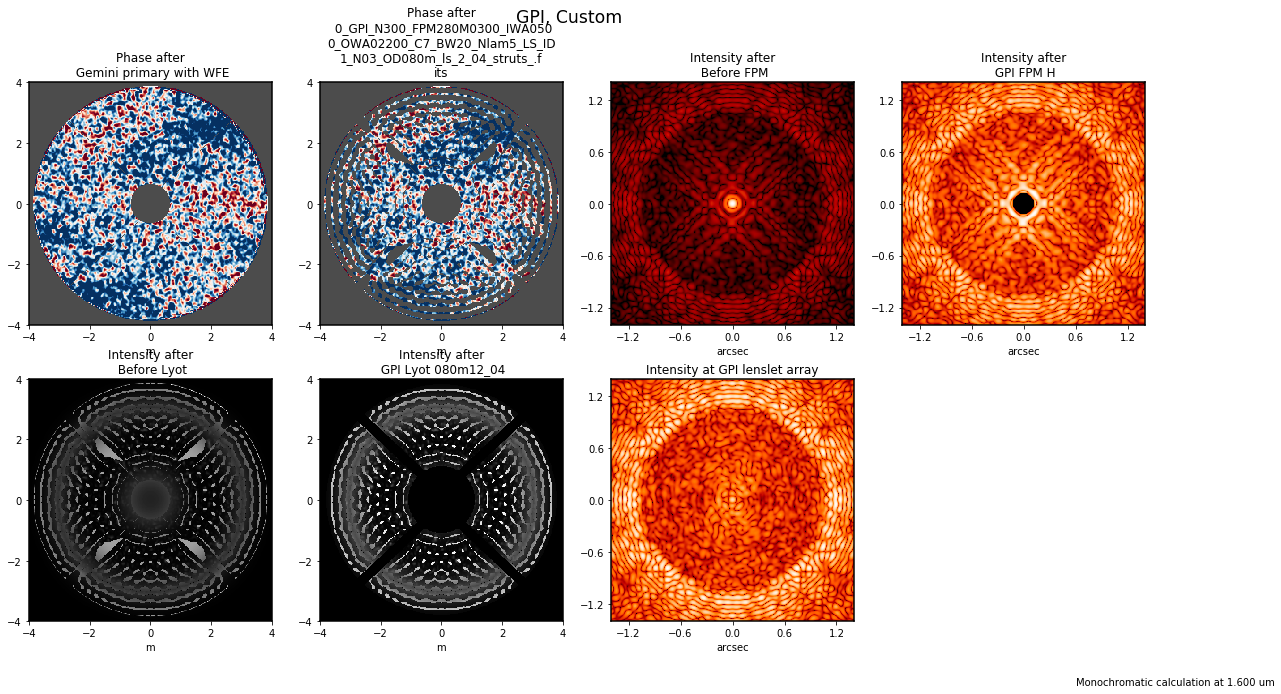

In [40]:
plt.figure(figsize=(20,10))

psf_new = gpi.calc_psf(monochromatic=1.6e-6, display=True, oversample=4)

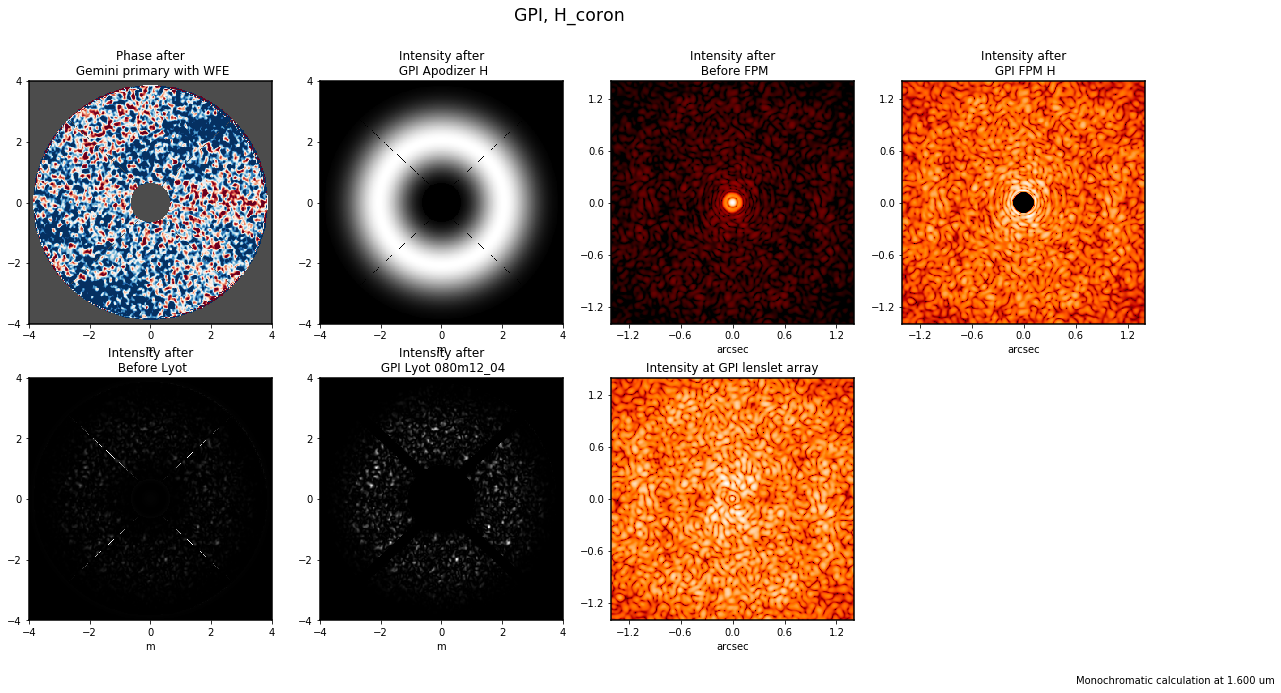

In [41]:
plt.figure(figsize=(20,10))

gpi.satspots=False
gpi.obsmode = 'H_coron'
psf_current = gpi.calc_psf(monochromatic=1.6e-6, display=True, oversample=4)

/Users/mperrin/software/poppy/poppy/utils.py:493: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1)
/Users/mperrin/software/poppy/poppy/utils.py:499: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)


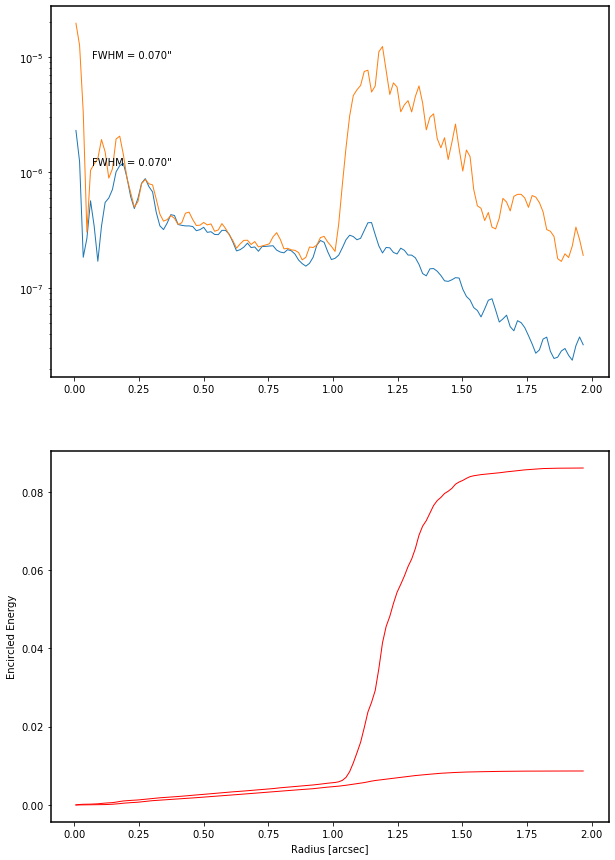

In [43]:
plt.figure(figsize=(10,15))
poppy.display_profiles(psf_current)
poppy.display_profiles(psf_new, overplot=True)

In [62]:
gpi.obsmode = 'H_coron'
area_h_coron = gpi.get_optical_system().planes[1].sample(npix=300, grid_size=8.0).sum()

gpi = gpipsfs.GPI(custom_apodizer_path=apod_fn, lyot_tabs=False, npix=300, display_before=True)
area_new = gpi.get_optical_system().planes[1].amplitude.sum()




In [63]:
area_new / area_h_coron

1.0511318979022495

In [58]:
gpi.get_optical_system().planes

40669.89058049369